In [1]:
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, OperatorStateFn
from qiskit.utils import QuantumInstance
import matplotlib.pyplot as plt
from qiskit_utils import BinaryObjectiveFunction
from data_utils import circle, plot_data, generate_ds
import numpy as np
# Set a random seed
np.random.seed(42)

In [2]:
# Generate training and test data
num_training = 200
num_test = 2000

X_train, y_train, new_y_train = generate_ds(num_training)
X_test, y_test, new_y_test= generate_ds(num_test)

In [3]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

In [6]:
# construct parametrized circuit
from qiskit_machine_learning.neural_networks import OpflowQNN

inputs = ParameterVector('input', length=4) # 1 extra for label
# inputs = ParameterVector('input', length=3)
weights = ParameterVector('weight', length=15)

# 1qubit classifier
qc1 = QuantumCircuit(1)
qc1.rz(inputs[0]*weights[0]+inputs[1]*weights[1]+inputs[2]*weights[2] + weights[3],0)
qc1.ry(weights[4],0)
qc1.rz(inputs[0]*weights[5]+inputs[1]*weights[6]+inputs[2]*weights[7] + weights[8],0)
qc1.ry(weights[9],0)
qc1.rz(inputs[0]*weights[10]+inputs[1]*weights[11]+inputs[2]*weights[12] + weights[13],0)
qc1.ry(weights[14],0)
qc_sfn1 = StateFn(qc1)

H1 = StateFn(PauliSumOp.from_list([('Z', 1.0)]))  
H2 = StateFn(PauliSumOp.from_list([('Z', -1.0)]))  

op1 = ~H1 @ (qc_sfn1)
op2 = ~H2 @ (qc_sfn1)
print(op1)
print(len(weights))

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
       »
  q_0: »
       »
  «     ┌──────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[0] + input[1]*weight[1] + input[2]*weight[2] + weight[3]) ├»
  «     └──────────────────────────────────────────────────────────────────────────────┘»
  «     ┌───────────────┐»
  «q_0: ┤ Ry(weight[4]) ├»
  «     └───────────────┘»
  «     ┌──────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[5] + input[1]*weight[6] + input[2]*weight[7] + weight[8]) ├»
  «     └──────────────────────────────────────────────────────────────────────────────┘»
  «     ┌───────────────┐»
  «q_0: ┤ Ry(weight[9]) ├»
  «     └───────────────┘»
  «     ┌──────────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[10] + input[1]*weight[11] + input[2]*weight[12] + weight[13]) ├»
  «     └───────────

In [7]:
# construct OpflowQNN with the operator, the input parameters, the weight parameters,
# the expected value, gradient, and quantum instance.
qnn1 = OpflowQNN(op1, inputs, weights, expval, gradient, qi_sv, input_gradients=True)
qnn2 = OpflowQNN(op2, inputs, weights, expval, gradient, qi_sv, input_gradients=True)

In [8]:
from qiskit.algorithms.optimizers import ADAM, L_BFGS_B
from qiskit_machine_learning.utils.loss_functions import L2Loss

losses = []
def callback_fn(avg_loss, weights):
    print("weights: ", weights)
    print("loss: ", avg_loss)
    losses.append(avg_loss)

function = BinaryObjectiveFunction(X_train, new_y_train, qnn1, qnn2, L2Loss(), callback_fn)

In [20]:
losses = []
# optimizer = ADAM(maxiter=30, lr=0.8)
optimizer = L_BFGS_B(maxiter=50)
# fit_result = optimizer.minimize(
fit_result = optimizer.optimize(
    num_vars=qnn1.num_weights,
    objective_function=function.objective,
    initial_point=algorithm_globals.random.random(qnn1.num_weights),
    gradient_function=function.gradient,
)

<bound method BinaryObjectiveFunction.gradient of <__main__.BinaryObjectiveFunction object at 0x0000016D1DE5B730>>
weights:  [0.95308645 0.67008829 0.85223113 0.90210113 0.1195655  0.59731135
 0.1028482  0.01160264 0.16869933 0.55863289 0.73696721 0.65626574
 0.37927727 0.45283662 0.14721994]
loss:  1.6235171779482913
weights:  [0.95308645 0.67008829 0.85223113 0.90210113 0.68572838 0.56668633
 0.09908887 0.01160264 0.15144057 1.22835803 0.70009437 0.63750786
 0.37927727 0.42199129 0.62368091]
loss:  1.432631653479909
weights:  [0.95308645 0.67008829 0.85223113 0.90210113 0.46846384 0.55803053
 0.09937135 0.01160264 0.20222176 0.995646   0.69280836 0.64364063
 0.37927727 0.48779513 0.42995747]
loss:  1.103319924446802
weights:  [0.95308645 0.67008829 0.85223113 0.90210113 0.30224888 0.46339261
 0.08458544 0.01160264 0.19184013 0.89191567 0.60110619 0.61722805
 0.37927727 0.49978523 0.2125935 ]
loss:  1.1222765144618863
weights:  [0.95308645 0.67008829 0.85223113 0.90210113 0.39420749 0

loss:  0.5210725415568358
weights:  [ 0.95308645  0.67008829  0.85223113  0.90210113  0.33704423  2.15188688
  2.37077193  0.01160264  2.72875047  1.15829136  3.8802372   0.40719815
  0.37927727 -0.02889925 -1.13774103]
loss:  0.5101807442509285
weights:  [ 9.53086454e-01  6.70088291e-01  8.52231126e-01  9.02101129e-01
  4.02085118e-01  2.24823919e+00  2.39078432e+00  1.16026381e-02
  2.77090290e+00  1.22710724e+00  3.82870729e+00  2.68330191e-01
  3.79277273e-01  5.34498946e-04 -1.10771952e+00]
loss:  0.47803449062835185
weights:  [ 0.95308645  0.67008829  0.85223113  0.90210113  0.84093478  1.78767074
  5.139953    0.01160264  2.94320286  1.73661011  2.77230131 -0.34742004
  0.37927727  0.07022037 -0.9729598 ]
loss:  0.6682274854528594
weights:  [ 0.95308645  0.67008829  0.85223113  0.90210113  0.57052342  2.07146483
  3.44596413  0.01160264  2.83703468  1.4226635   3.4232399   0.03199431
  0.37927727  0.02728117 -1.05599634]
loss:  0.37521728023945855
weights:  [ 0.95308645  0.67008

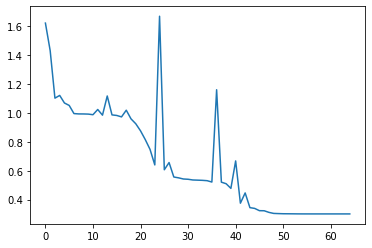

In [21]:
plt.plot(losses)

In [9]:
ws = [ 0.95308645,  0.67008829,  0.85223113,  0.90210113,  0.75605125,
        2.54158398,  3.20566835,  0.01160264,  3.02580588,  1.85796094,
        3.07684783,  0.1742631 ,  0.37927727,  0.01221246, -1.37817648]

from test_utils import get_metrics
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_train, qnn1, ws)

Accuracy:  0.845
tp:  81 tn:  88  fp:  18  fn:  13


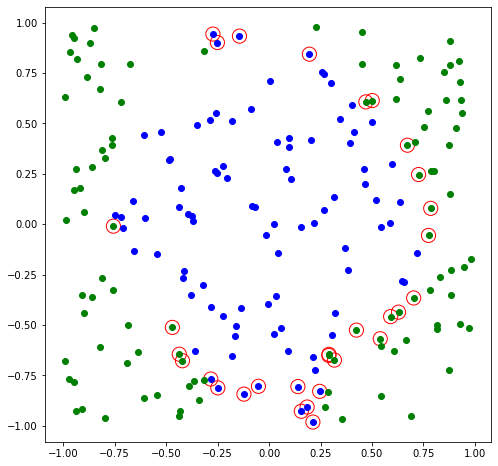

In [10]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_train, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()

In [11]:
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_train, qnn1, ws)

Accuracy:  0.845
tp:  81 tn:  88  fp:  18  fn:  13


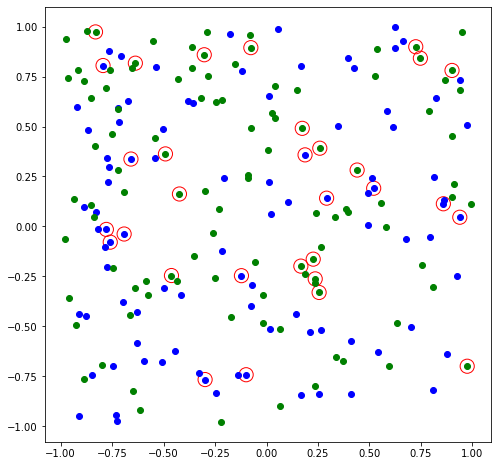

In [12]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_test, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()